In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import tqdm

In [2]:
TENSORDTYPE = torch.float32

In [3]:
DEVICE = 'cuda:0'

In [4]:
LOGROOTDIR = './plot-fig34-data/'

if not os.path.exists(LOGROOTDIR):
    os.mkdir(LOGROOTDIR)

All problem-specific functions accpet tensor arguments.

Take $f(t,x,a)$ as an example. We assume its inputs $t, x$ and $a$ are tensors with at least 1 dimension. All dimensions except the last are regarded as batch dimensions and are equivalent in function bodies. The outputs follow this rule too. This means even the time input $t$ and the value $f(t,x,a)$ are both scalar in their definition, we force them to be tensors in shape (1,) too.

We also adopt the sequence-first convention, which is standard in seq2seq training. Most Tensors have shape (T, M, D), where

- T : time axis
- M : batch axis
- D : original dim of this quantity

# Helper Function

In [5]:
def re_cumsum(t, dim):
    r'''torch.cumsum in reverse direction'''
    return t + torch.sum(t, dim, keepdim=True) - torch.cumsum(t, dim)

# Problem

Solve the following FBSDE
\begin{align*}
X_s &= x + \int_t^s\sigma_0(\hat{b}_0\alpha_s\,ds + dW_s) \\
Y_s &= g(X_T) + \int_s^T\|\alpha_\tau\|^2\,d\tau - \int_s^T\langle Z_\tau, dW_\tau\rangle.
\end{align*}
Define $R_s = g(X_T) + \int_s^T\|\alpha_\tau\|^2\,d\tau$.

Observation:
1. $R_s$ is not adapted;
2. $R_t$ is normally distributed with mean 0 and variance $\int_t^T\|Z_s\|^2\,ds$.

Solve the following FBSDE
\begin{align*}
X_s &= x + \int_t^s\sigma_0(\hat{b}_0\alpha^0_s\,ds + dW_s) \\
Y_s &= g(X_T) + \int_s^T\|\alpha_\tau\|^2\,d\tau - \int_s^T\langle Z_\tau, dW_\tau - \hat{b}_0(\alpha_\tau - \alpha_\tau^0)\,d\tau\rangle.
\end{align*}
Define $\lambda^b(\omega)=\exp\bigl(\int_0^T\hat{b}_0(\alpha_s-\alpha^0_s)dW_s - \frac{1}{2}\int_0^T\hat{b}_0^2\|\alpha_s - \alpha_s^0\|^2\,ds\bigr)$.

Solve the stochastic optimal control problem:
\begin{align}
\operatorname{minimize}\quad& \operatorname{\mathbb{E}}\biggl[g(X_T)+\int_t^T\|\alpha_\tau\|^2\,d\tau\biggr], \\
\operatorname{subject to}\quad& X_s = x + \int_t^s\sigma_0(\hat{b}_0\alpha_\tau\,d\tau + dW_\tau).
\end{align}
By Hopf-Cole transformation, the optimal cost at $(t,x)$ is
$$ -\frac{2}{\hat{b}_0^2}\ln\biggl(\operatorname{\mathbb{E}}\bigl[ \exp\bigl(-\frac{\hat{b}_0^2}{2}g(x+\sigma_0 W_{T-t}\bigr) \bigr]\biggr).$$

In [6]:
class Example3(object):
    
    n = 100            # state dim

    def __init__(self):
        self.H = 100            # step nums
        self.dt = 0.01          # step size
        self.m = 16             # batch size

        self.hat_b_0 = 1.0
        self.sigma_0 = np.sqrt(2.0)
        self.Umax = float('100')
        
        self.ctrl = lambda t, x: torch.zeros_like(x)

    def mu(self, t, x, z):
        return torch.clamp(-self.hat_b_0*z*.5, min=-self.Umax, max=self.Umax)

    @torch.no_grad()
    def sample_data(self, t0=0., x0=0., *, batch_num=None, ctrl=None):
        ctrl = ctrl or self.ctrl
        m = batch_num or self.m
        
        # discrete time points
        t = t0 + torch.tensor([self.dt*i for i in range(1+self.H)], dtype=TENSORDTYPE, device=DEVICE,
                             ).reshape(-1,1,1).expand(-1, m, 1)

        # sample noise dW
        dW = torch.normal(0., np.sqrt(self.dt), size=(self.H+1, m, self.n), dtype=TENSORDTYPE, device=DEVICE)
        # there are only H time interval and dW[-1] is only a placeholder.
        dW[-1] = 0.

        # simulate forward process with Euler scheme
        X = torch.empty(1+self.H, m, self.n, dtype=TENSORDTYPE, device=DEVICE)
        U = torch.empty(1+self.H, m, self.n, dtype=TENSORDTYPE, device=DEVICE)
        X[0] = x0
        U[0] = ctrl(t[0], X[0])
        for i in range(self.H):
            X[i+1] = X[i] + self.sigma_0*(dW[i]+self.hat_b_0*U[i]*self.dt)
            U[i+1] = ctrl(t[i+1], X[i+1])

        f_s = self.f(t, X, U)
        f_s[-1] = self.g(X[-1])

        R = re_cumsum(f_s[:-1], dim=0) * self.dt + f_s[-1]
        R = torch.cat([R, f_s[-1:]], dim=0)
        
        return (
            t, X, U, f_s, R, dW,
        )
    
    @torch.no_grad()
    def off_process_data(self, current_ctrl, t_series, x_series, u_series, g_series, r_series, dw_series):
        U = current_ctrl(t_series, x_series)
        
        f_s = self.f(t_series, x_series, U)
        f_s[-1] = self.g(x_series[-1])

        R = re_cumsum(f_s[:-1], dim=0) * self.dt + f_s[-1]
        R = torch.cat([R, f_s[-1:]], dim=0)

        b_series = self.hat_b_0*(U - u_series)
        
        return (
            t_series, x_series, b_series, f_s, R, dw_series
        )


    def f(self, t, x, a):
        return torch.sum(torch.square(a), -1, keepdim=True)
    
    def g(self, x):
        return torch.log(.5*(1+torch.sum(x*x, -1, keepdim=True)))
    
    def get_optimal_cost(self, x0=0., *, batch_num=None):
        m = batch_num or self.m
        X = x0 + self.sigma_0*torch.normal(0., np.sqrt(self.H*self.dt), size=(1, m, self.n),dtype=TENSORDTYPE, device=DEVICE)
        factor = self.hat_b_0*self.hat_b_0*.5
        return -torch.log(torch.mean(torch.exp(-factor*self.g(X)))).item()/factor

In [7]:
# test sample data
fbsde = Example3()
fbsde.m = 16
fbsde.sigma_0 = np.sqrt(20.0)

opt_costs = []
for _ in tqdm.trange(50):
    data = fbsde.sample_data()
    t, x, u, g, r, _ = data

    
    err = r - torch.stack([g[-1] + fbsde.dt * torch.sum(g[i:-1], dim=0) for i in range(g.shape[0])])
    err = err.abs().max()
    
    opt_costs.append(-1/50*torch.log(torch.mean(torch.exp(-50*r[-1]))).item())
    
    if err > 1e-12:
        break

for s in data:
    print(s.shape)

100%|██████████| 50/50 [00:01<00:00, 28.86it/s]

torch.Size([101, 16, 1])
torch.Size([101, 16, 100])
torch.Size([101, 16, 100])
torch.Size([101, 16, 1])
torch.Size([101, 16, 1])
torch.Size([101, 16, 100])


# Basic Nets

In [8]:
class FCNet2(torch.nn.Module):

    def __init__(self, xdim, wdim, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.linear1 = torch.nn.Linear(1+xdim, hidden_size, bias=True)
        self.head = torch.nn.Linear(hidden_size, wdim)
        self.activation = torch.nn.ReLU()
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def init_parameters_(self):
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.normal_(self.linear1.bias)
        torch.nn.init.xavier_uniform_(self.head.weight)
        torch.nn.init.normal_(self.head.bias)
        
    def forward(self, t, x):
        z = torch.cat([1-t, x], dim=-1)
        z = self.activation(self.linear1(z))
        return self.head(z)
    
    @torch.no_grad()
    def get_derivative(self, t, x):
        z = self.linear1(torch.cat([1-t, x], dim=-1))
        grad = (self.linear1.weight.T * (z.unsqueeze(-2) > 0.) @ self.head.weight.T).squeeze(-1)
        return grad[...,1:]

# Model

In [9]:
class Model1(torch.nn.Module):
    
    def __init__(self, xdim, wdim, hidden_size, hidden_layers=2):
        super().__init__()
        if hidden_layers == 2:
            self.znet = FCNet2(xdim, wdim, hidden_size)
        elif hidden_layers == 3:
            self.znet = FCNet3(xdim, wdim, hidden_size)
        self.register_parameter("y0", torch.nn.Parameter(torch.tensor([1.])))
        
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        return self.znet(t, x)
    
    
class Model2(torch.nn.Module):
    def __init__(self, xdim, wdim, hidden_size, hidden_layers=2):
        super().__init__()
        if hidden_layers == 2:
            self.ynet = FCNet2(xdim, 1, hidden_size)
        elif hidden_layers == 3:
            self.ynet = FCNet3(xdim, 1, hidden_size)
 
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        return self.ynet(t, x)
    
    
class Model3(torch.nn.Module):
    def __init__(self, xdim, wdim, hidden_size, hidden_layers=2):
        super().__init__()
        if hidden_layers == 2:
            self.ynet = FCNet2(xdim, 1, hidden_size)
            self.znet = FCNet2(xdim, wdim, hidden_size)
        elif hidden_layers == 3:
            self.ynet = FCNet3(xdim, 1, hidden_size)
            self.znet = FCNet3(xdim, wdim, hidden_size)
        
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        return self.ynet(t, x), self.znet(t,x)
    

class Model5(torch.nn.Module):
    
    def __init__(self, xdim, wdim, hidden_size, hidden_layers=2):
        super().__init__()
        if hidden_layers == 2:
            self.znet = FCNet2(xdim, wdim, hidden_size)
        elif hidden_layers == 3:
            self.znet = FCNet3(xdim, wdim, hidden_size)
        
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        return self.znet(t, x)

# Calculate Loss

Loss 1 (Deep BSDE):
$$ \operatorname{\mathbb{E}} |\widetilde{Y}_t - y|^2. $$

In [10]:
def calc_loss_1(model, dt, t_series, x_series, u_series, g_series, r_series, dw_series):
    r'''Deep BSDE Loss'''
    z_series = model.znet(t_series, x_series)
    m0 = torch.sum(torch.sum(z_series*dw_series, dim=-1, keepdim=True), dim=0)
    loss = torch.square(r_series[0] - m0 - model.y0).mean()
    return loss

def calc_loss_1_off(model, dt, t_series, x_series, b_series, g_series, r_series, dw_series):
    z_series = model.znet(t_series, x_series)
    m0 = torch.sum(torch.sum(z_series*(dw_series-b_series*dt), dim=-1, keepdim=True)[:-1], dim=0)
    loss = torch.square(r_series[0] - m0 - model.y0).mean()
    return loss

Loss 2 (Deep BSDE-ML):
$$ \operatorname{\mathbb{E}} |\widetilde{Y}_t - \operatorname{\mathbb{E}}\widetilde{Y}_t|^2. $$

In [11]:
def calc_loss_2(model, dt, t_series, x_series, u_series, g_series, r_series, dw_series):
    r'''Deep BSDE-ML Loss'''
    z_series = model.znet(t_series, x_series)
    m0 = torch.sum(torch.sum(z_series*dw_series, dim=-1, keepdim=True), dim=0)
    loss = (r_series[0] - m0).var()
    return loss

def calc_loss_2_off(model, dt, t_series, x_series, b_series, g_series, r_series, dw_series):
    z_series = model.znet(t_series, x_series)
    m0 = torch.sum(torch.sum(z_series*(dw_series-b_series*dt), dim=-1, keepdim=True)[:-1], dim=0)
    loss = (r_series[0] - m0).var()
    return loss

Loss 7 (ML):
$$ \int_t^T\operatorname{\mathbb{E}} |R_s - \tilde{v}_s|^2\,ds. $$

In [12]:
def calc_loss_7(model, dt, t_series, x_series, u_series, g_series, r_series, dw_series):
    r'''Martingale Loss'''
    y_series = model.ynet(t_series, x_series)
    loss = torch.sum(torch.square(r_series - y_series).mean(dim=1, keepdim=True)) * dt
    return loss

def calc_loss_7_off(model, dt, t_series, x_series, b_series, g_series, r_series, dw_series):
    y_series = model.ynet(t_series, x_series)
    loss = torch.sum(torch.square(r_series - y_series).mean(dim=1, keepdim=True)) * dt
    return loss


Loss 8:
$$ \int_t^T\operatorname{\mathbb{E}} |\widetilde{Y}_s - \tilde{v}_s|^2\,ds. $$

In [13]:
def calc_loss_8(model, dt, t_series, x_series, u_series, g_series, r_series, dw_series):
    y_series, z_series = model(t_series, x_series)
    m_series = re_cumsum(torch.sum(z_series*dw_series, dim=-1, keepdim=True), 0)
    loss = torch.sum(torch.square(r_series - m_series - y_series).mean(dim=1, keepdim=True)) * dt
    return loss

def calc_loss_8_off(model, dt, t_series, x_series, b_series, g_series, r_series, dw_series):
    y_series, z_series = model(t_series, x_series)
    m_series = torch.sum(z_series*(dw_series-b_series*dt), dim=-1, keepdim=True)
    m_series = torch.cat([m_series[:-1], torch.zeros_like(m_series[-1:])], dim=0)
    m_series = re_cumsum(m_series, 0)
    loss = torch.sum((torch.square(r_series - m_series - y_series)).mean(dim=1, keepdim=True))*dt
    return loss

Other metric

In [14]:
def calc_metric_y(model, dt, t_series, x_series, u_series, g_series, r_series, dw_series):
    y0 = model.ynet(t_series[0], x_series[0]).mean()
    return (y0 - r_series[0].mean()).abs()

def calc_metric_z(model, dt, t_series, x_series, u_series, g_series, r_series, dw_series):
    z_series = model.znet(t_series, x_series)
    m0 = torch.sum(torch.sum(z_series*dw_series, dim=-1, keepdim=True), dim=0)
    loss = (r_series[0] - m0).var()
    return loss

def calc_impr_cost(model, sde):
    t, x, u, g, r, dW = sde.sample_data(batch_num=12800, ctrl=lambda t,x:sde.mu(t, x, model.znet(t, x)))
    return r[0].mean(), r[0].std()

# Policy Evaluation

In [15]:
def on_policy_evaluation(sde, calc_loss, model, optimizer, scheduler, *, max_epi=200, log_all=True):
    valid_data = sde.sample_data(batch_num=12800)
    
    para_log = []
    model.train(True)
    optimizer.zero_grad()
    
    for epi in range(max_epi):
        para_log.append({'grad step': epi})

        data = sde.sample_data()
        loss = calc_loss(model, sde.dt, *data)

        para_log[-1]['loss'] = loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.)

        optimizer.step()
        scheduler.step()

        optimizer.zero_grad()

        if log_all:
            model.train(False)
            with torch.no_grad():
                if hasattr(model, 'ynet'):
                    para_log[-1]['metric_y'] = calc_metric_y(model, sde.dt, *valid_data).item()
                if hasattr(model, 'y0'):
                    para_log[-1]['metric_y'] = abs(model.y0.item() - valid_data[-2][0].mean().item() )
                if hasattr(model, 'znet'):
                    para_log[-1]['metric_z'] = calc_metric_z(model, sde.dt, *valid_data).item()

                    impr_cost_mean, impr_cost_std = calc_impr_cost(model, sde)
                    para_log[-1]['cost_mean'] = impr_cost_mean.item()
                    para_log[-1]['cost_std'] = impr_cost_std.item()
            model.train(True)

    return para_log

In [16]:
def off_policy_evaluation(sde, calc_loss, model, optimizer, scheduler, behavior_policy, *, max_epi=200, log_all=True):
    if hasattr(model, 'znet'):
        target_policy = lambda t, x:sde.mu(t, x, model.znet(t, x))
    else:
        target_policy = lambda t, x:sde.mu(t, x, model.ynet.get_derivative(t, x)*sde.sigma_0)
    
    para_log = []
    model.train(True)
    optimizer.zero_grad()
    
    for epi in range(max_epi):
        para_log.append({'grad step': epi})

        data = sde.sample_data(ctrl=behavior_policy)
        
        # process data with the target policy
        model.train(False)
        data = sde.off_process_data(target_policy, *data)
        model.train(True)
        
        loss = calc_loss(model, sde.dt, *data)

        para_log[-1]['loss'] = loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.)

        optimizer.step()
        scheduler.step()

        optimizer.zero_grad()

        if log_all:
            model.train(False)
            with torch.no_grad():
                # valid data change with the target policy
                valid_data = sde.sample_data(batch_num=12800, ctrl=target_policy)
                if hasattr(model, 'ynet'):
                    para_log[-1]['metric_y'] = calc_metric_y(model, sde.dt, *valid_data).item()
                if hasattr(model, 'y0'):
                    para_log[-1]['metric_y'] = abs(model.y0.item() - valid_data[-2][0].mean().item() )
                if hasattr(model, 'znet'):
                    para_log[-1]['metric_z'] = calc_metric_z(model, sde.dt, *valid_data).item()

                    para_log[-1]['cost_mean'] = valid_data[-2][0].mean().item()
                    para_log[-1]['cost_std'] = valid_data[-2][0].std().item()
            model.train(True)

    return para_log

In [17]:
def create_optimizer(model, lr_configs):
    out = []
    if hasattr(model, 'y0'):
        out.append({'params': model.y0})
        out[-1].update(lr_configs['y0'])
    if hasattr(model, 'ynet'):
        out.append({'params': model.ynet.parameters(), })
        out[-1].update(lr_configs['znet'])
    if hasattr(model, 'znet'):
        out.append({'params': model.znet.parameters(), })
        out[-1].update(lr_configs['znet'])
    return torch.optim.SGD(out)

# Experiment I
PI starting at $\alpha(t,x)\equiv -0.1x$ with $\hat{b}_0=1.0, \sigma_0=\sqrt{2}$ and the on-policy and off-policy subroutine.

In [18]:
sde = Example3()
sde.m = 16
sde.hat_b_0 = 1.0
sde.sigma_0 = np.sqrt(2.)
initial_ctrl = lambda t,x: -0.1*x
initial_cost = sde.sample_data(ctrl=initial_ctrl, batch_num=12800)[-2][0].mean().item()
D = {
    'net_configs': {
        'xdim': sde.n,
        'wdim': sde.n,
        'hidden_size': 16,
        'hidden_layers': 2,
    },
    'lr_configs': {
        'y0': {
            'lr': 0.5,
        },
        'ynet': {
            'lr': 0.01,
            'momentum': 1e-3,
            'nesterov': True,
        },
        'znet': {
            'lr': 0.1,
            'momentum': 1e-3,
            'nesterov': True,
        },
    },
    'max_epi': 75,
}
cost_logs = [[] for _ in range(8)]
model_loss_pairs = [
    [Model1, calc_loss_1],
    [Model5, calc_loss_2],
    [Model2, calc_loss_7],
    [Model3, calc_loss_8],
    [Model1, calc_loss_1_off],
    [Model5, calc_loss_2_off],
    [Model2, calc_loss_7_off],
    [Model3, calc_loss_8_off],
]
for run_i in range(5):
  
    for pair_i, (model_cls, calc_loss) in tqdm.tqdm(enumerate(model_loss_pairs)):
        model = model_cls(**D['net_configs'])
        optimizer = create_optimizer(model, D['lr_configs'])
      
        mode = 'off-policy' if calc_loss.__name__.endswith('off') else 'on-policy'
      
        previous_model = model_cls(**D['net_configs'])
        previous_model.train(False)
        cost_logs[pair_i].append({'mode': mode, 'LossNum': calc_loss.__name__, 
                                  'run': run_i, 'iteration': 0, 'cost': initial_cost,})
      
        sde.ctrl = initial_ctrl
      
        for iter_i in range(1, 10):
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
            if mode == 'on-policy':
                on_policy_evaluation(sde, calc_loss, model, optimizer, scheduler, max_epi=D['max_epi'], log_all=False)
            elif mode == 'off-policy':
                off_policy_evaluation(sde, calc_loss, model, optimizer, scheduler, behavior_policy=initial_ctrl, max_epi=D['max_epi'], log_all=False)
            previous_model.load_state_dict(model.state_dict())
            if hasattr(previous_model, 'znet'):
                sde.ctrl = lambda t, x:sde.mu(t, x, previous_model.znet(t, x))
            else:
                sde.ctrl = lambda t, x:sde.mu(t, x, previous_model.ynet.get_derivative(t, x)*sde.sigma_0)
              
            cost_logs[pair_i].append({'mode': mode, 'LossNum': calc_loss.__name__, 
                                      'run': run_i, 'iteration': iter_i, 
                                      'cost': sde.sample_data(batch_num=12800)[-2][0].mean().item(),})
          
expI_cost_logs = cost_logs.copy()

8it [02:04, 15.54s/it]
8it [02:01, 15.17s/it]
8it [02:05, 15.65s/it]
8it [02:01, 15.24s/it]
8it [02:03, 15.42s/it]


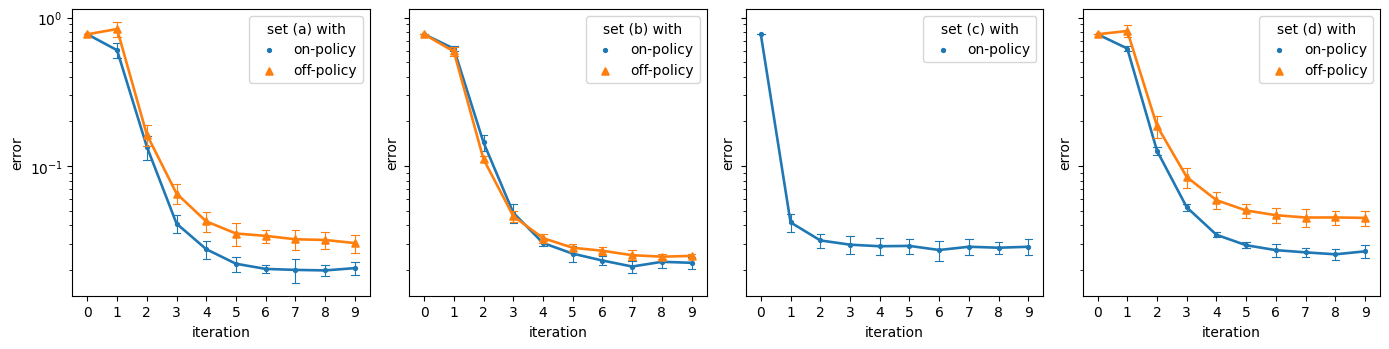

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3.6), sharey=True)
palette = {'on-policy': 'C0', 'off-policy': 'C1'}
optimal_cost = sde.get_optimal_cost(batch_num=12800)
logs = [cost_logs[0] + cost_logs[4],
        cost_logs[1] + cost_logs[5],
        cost_logs[2],
        cost_logs[3] + cost_logs[7]]
for i in range(4):
    name = 'set ({})'.format(chr(97+i))
    df = pd.DataFrame(logs[i])
    df.cost = (df.cost - optimal_cost).abs()
  
    df = df.rename(columns={'cost': 'error', 'mode': f"{name} with"})
  
    sns.pointplot(
        x='iteration', y='error', errorbar='sd', hue=f'{name} with', markers=['.', '^'],
        ax=axes[i], data=df, palette=palette, errwidth=.8, capsize=.25, scale=0.7,
    )
  
for i, ax in enumerate(axes):
    ax.set_yscale('log')
    #ax.set_ylim(1e-6, 1e-0)
  
fig.tight_layout()

In [21]:
pd.concat([pd.DataFrame(log) for log in cost_logs], ignore_index=True, sort=True).to_csv(os.path.join(
    LOGROOTDIR, 'fig3.csv'
))

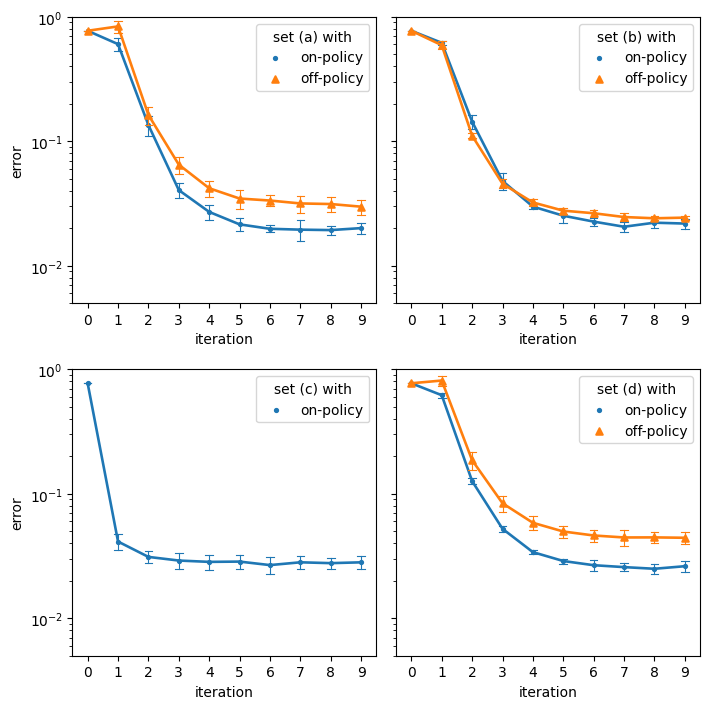

In [22]:
sde = Example3()
sde.m = 16
sde.hat_b_0 = 1.0
sde.sigma_0 = np.sqrt(2.)

initial_ctrl = lambda t,x: -0.1*x
initial_cost = sde.sample_data(ctrl=initial_ctrl, batch_num=12800)[-2][0].mean().item()

D = {
    'net_configs': {
        'xdim': sde.n,
        'wdim': sde.n,
        'hidden_size': 16,
        'hidden_layers': 2,
    },
    'lr_configs': {
        'y0': {
            'lr': 0.5,
        },
        'ynet': {
            'lr': 0.01,
            'momentum': 1e-3,
            'nesterov': True,
        },
        'znet': {
            'lr': 0.1,
            'momentum': 1e-3,
            'nesterov': True,
        },
    },
    'max_epi': 75,
}

cost_logs = pd.read_csv(os.path.join(LOGROOTDIR, 'fig3.csv'))
if 'Unnamed: 0' in cost_logs.columns:
    cost_logs = cost_logs.drop(columns=['Unnamed: 0'])

idx_list = [list(range(i*50,i*50+50)) for i in range(8)]
logs = [
    cost_logs.iloc[idx_list[0] + idx_list[4]],
    cost_logs.iloc[idx_list[1] + idx_list[5]],
    cost_logs.iloc[idx_list[2]],
    cost_logs.iloc[idx_list[3] + idx_list[7]],
]

fig, axes = plt.subplots(2, 2, figsize=(7.2, 7.2), sharey=True)
axes = axes.flatten()
palette = {'on-policy': 'C0', 'off-policy': 'C1'}
optimal_cost = sde.get_optimal_cost(batch_num=12800)

for i in range(4):
    name = 'set ({})'.format(chr(97+i))
    df = pd.DataFrame(logs[i])
    df.cost = (df.cost - optimal_cost).abs()
    
    df = df.rename(columns={'cost': 'error', 'mode': f"{name} with"})
    
    sns.pointplot(
        x='iteration', y='error', errorbar='sd', hue=f'{name} with', markers=['.', '^'],
        ax=axes[i], data=df, palette=palette, errwidth=.8, capsize=.25, scale=0.7,
    )
    
for i, ax in enumerate(axes):
    ax.set_yscale('log')
    ax.set_ylim(5e-3, 1e-0)
    
axes[1].set_ylabel('')
axes[3].set_ylabel('')

    
fig.tight_layout()

In [23]:
fig.savefig('./fig-3.pdf')

# Experiment IV
PI starting at $\alpha(t,x)\equiv -0.1x$ with $\hat{b}_0=1.0, \sigma_0=\sqrt{20}$ and the on-policy and off-policy subroutine.

In [24]:
sde = Example3()
sde.m = 64
sde.hat_b_0 = 1.0
sde.sigma_0 = np.sqrt(20.)
initial_ctrl = lambda t,x: -0.1*x
initial_cost = sde.sample_data(ctrl=initial_ctrl, batch_num=12800)[-2][0].mean().item()
D = {
    'net_configs': {
        'xdim': sde.n,
        'wdim': sde.n,
        'hidden_size': 16,
        'hidden_layers': 2,
    },
    'lr_configs': {
        'y0': {
            'lr': 0.5,
        },
        'ynet': {
            'lr': 0.01,
            'momentum': 1e-3,
            'nesterov': True,
        },
        'znet': {
            'lr': 0.1,
            'momentum': 1e-3,
            'nesterov': True,
        },
    },
    'max_epi': 75,
}
cost_logs = [[] for _ in range(8)]
model_loss_pairs = [
    [Model1, calc_loss_1],
    [Model5, calc_loss_2],
    [Model2, calc_loss_7],
    [Model3, calc_loss_8],
    [Model1, calc_loss_1_off],
    [Model5, calc_loss_2_off],
    [Model2, calc_loss_7_off],
    [Model3, calc_loss_8_off],
]
for run_i in range(5):
  
    for pair_i, (model_cls, calc_loss) in tqdm.tqdm(enumerate(model_loss_pairs)):
        model = model_cls(**D['net_configs'])
        optimizer = create_optimizer(model, D['lr_configs'])
      
        mode = 'off-policy' if calc_loss.__name__.endswith('off') else 'on-policy'
      
        previous_model = model_cls(**D['net_configs'])
        previous_model.train(False)
        cost_logs[pair_i].append({'mode': mode, 'LossNum': calc_loss.__name__, 
                                  'run': run_i, 'iteration': 0, 'cost': initial_cost,})
      
        sde.ctrl = initial_ctrl
      
        for iter_i in range(1, 10):
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
            if mode == 'on-policy':
                on_policy_evaluation(sde, calc_loss, model, optimizer, scheduler, max_epi=D['max_epi'], log_all=False)
            elif mode == 'off-policy':
                off_policy_evaluation(sde, calc_loss, model, optimizer, scheduler, behavior_policy=initial_ctrl, max_epi=D['max_epi'], log_all=False)
            previous_model.load_state_dict(model.state_dict())
            if hasattr(previous_model, 'znet'):
                sde.ctrl = lambda t, x:sde.mu(t, x, previous_model.znet(t, x))
            else:
                sde.ctrl = lambda t, x:sde.mu(t, x, previous_model.ynet.get_derivative(t, x)*sde.sigma_0)
              
            cost_logs[pair_i].append({'mode': mode, 'LossNum': calc_loss.__name__, 
                                      'run': run_i, 'iteration': iter_i, 
                                      'cost': sde.sample_data(batch_num=12800)[-2][0].mean().item(),})
          
expIV_cost_logs = cost_logs.copy()

8it [01:59, 14.95s/it]
8it [01:58, 14.80s/it]
8it [01:58, 14.86s/it]
8it [01:58, 14.85s/it]
8it [01:58, 14.82s/it]


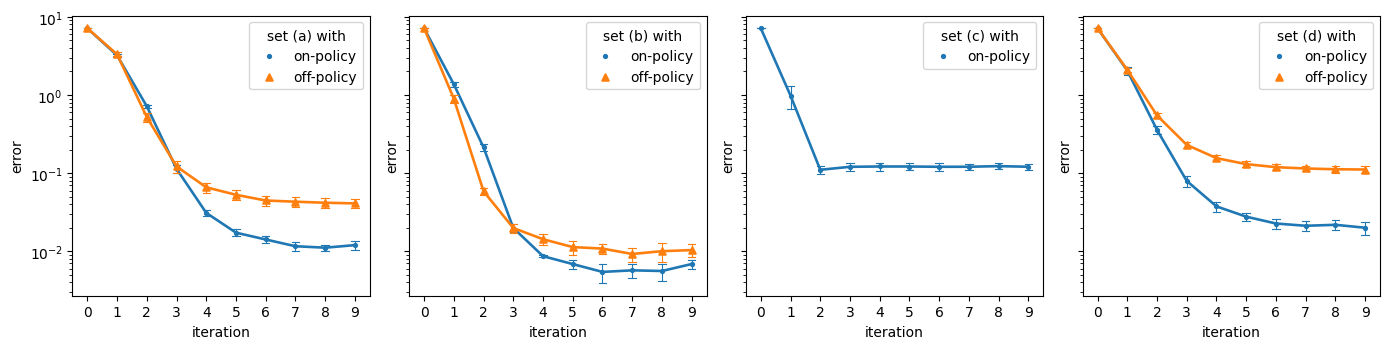

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3.6), sharey=True)
palette = {'on-policy': 'C0', 'off-policy': 'C1'}
optimal_cost = sde.get_optimal_cost(batch_num=12800)
logs = [cost_logs[0] + cost_logs[4],
        cost_logs[1] + cost_logs[5],
        cost_logs[2],
        cost_logs[3] + cost_logs[7]]
for i in range(4):
    name = 'set ({})'.format(chr(97+i))
    df = pd.DataFrame(logs[i])
    df.cost = (df.cost - optimal_cost).abs()
  
    df = df.rename(columns={'cost': 'error', 'mode': f"{name} with"})
  
    sns.pointplot(
        x='iteration', y='error', errorbar='sd', hue=f'{name} with', markers=['.', '^'],
        ax=axes[i], data=df, palette=palette, errwidth=.8, capsize=.25, scale=0.7,
    )
  
for i, ax in enumerate(axes):
    ax.set_yscale('log')
    #ax.set_ylim(1e-6, 1e-0)
  
fig.tight_layout()

In [26]:
pd.concat([pd.DataFrame(log) for log in cost_logs], ignore_index=True, sort=True).to_csv(os.path.join(
    LOGROOTDIR, 'fig4.csv'
))

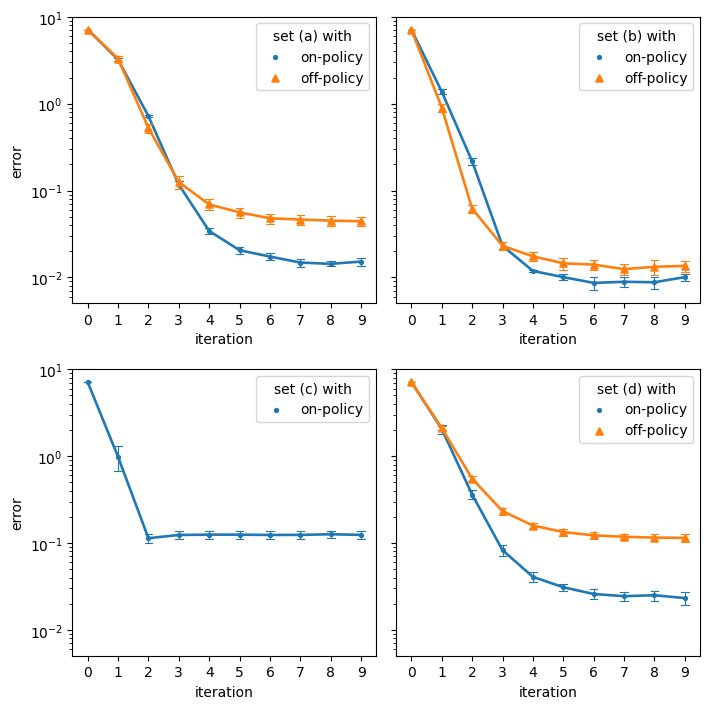

In [27]:
sde = Example3()
sde.m = 64
sde.hat_b_0 = 1.0
sde.sigma_0 = np.sqrt(20.)

initial_ctrl = lambda t,x: -0.1*x
initial_cost = sde.sample_data(ctrl=initial_ctrl, batch_num=12800)[-2][0].mean().item()

D = {
    'net_configs': {
        'xdim': sde.n,
        'wdim': sde.n,
        'hidden_size': 16,
        'hidden_layers': 2,
    },
    'lr_configs': {
        'y0': {
            'lr': 0.5,
        },
        'ynet': {
            'lr': 0.01,
            'momentum': 1e-3,
            'nesterov': True,
        },
        'znet': {
            'lr': 0.1,
            'momentum': 1e-3,
            'nesterov': True,
        },
    },
    'max_epi': 75,
}

cost_logs = pd.read_csv(os.path.join(LOGROOTDIR, 'fig4.csv'))
if 'Unnamed: 0' in cost_logs.columns:
    cost_logs = cost_logs.drop(columns=['Unnamed: 0'])

idx_list = [list(range(i*50,i*50+50)) for i in range(8)]
logs = [
    cost_logs.iloc[idx_list[0] + idx_list[4]],
    cost_logs.iloc[idx_list[1] + idx_list[5]],
    cost_logs.iloc[idx_list[2]],
    cost_logs.iloc[idx_list[3] + idx_list[7]],
]

fig, axes = plt.subplots(2, 2, figsize=(7.2, 7.2), sharey=True)
axes = axes.flatten()
palette = {'on-policy': 'C0', 'off-policy': 'C1'}
optimal_cost = sde.get_optimal_cost(batch_num=12800)

for i in range(4):
    name = 'set ({})'.format(chr(97+i))
    df = pd.DataFrame(logs[i])
    df.cost = (df.cost - optimal_cost).abs()
    
    df = df.rename(columns={'cost': 'error', 'mode': f"{name} with"})
    
    sns.pointplot(
        x='iteration', y='error', errorbar='sd', hue=f'{name} with', markers=['.', '^'],
        ax=axes[i], data=df, palette=palette, errwidth=.8, capsize=.25, scale=0.7,
    )
    
for i, ax in enumerate(axes):
    ax.set_yscale('log')
    #ax.set_ylim(1e-6, 1e-0)
    
axes[1].set_ylabel('')
axes[3].set_ylabel('')

    
fig.tight_layout()

In [28]:
fig.savefig('./fig-4.pdf')